In [1]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
os.sys.path.append("..")
from src.models.chexzero_plus.chexzero_lightning import ChexZero
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torch
from torchvision.transforms import Compose,Normalize,Resize,InterpolationMode

from torchxrayvision.datasets import XRayCenterCrop, XRayResizer, normalize, apply_transforms, relabel_dataset, SubsetDataset
from datawrappers import NIH_wrapper, CheX_wrapper, VINBig_wrapper
from src.datamodules.H5datasets import NIHDataset,VinbigDataset,MIMICDataset

import wandb

import torchxrayvision as xrv 

import numpy as np

input_resolution = 224
transform = Compose([
    Normalize((101.48761, 101.48761, 101.48761), (83.43944, 83.43944, 83.43944)),
    Resize(input_resolution, interpolation=InterpolationMode.BICUBIC),
])

transforms = Compose([XRayCenterCrop(),XRayResizer(224)])
nih_ds = NIH_wrapper(r"/mnt/mp1/@ais/nih_raw/%ob/",\
    csvpath=r"/mnt/mp1/@ais/nih_raw/%ob/Data_Entry_2017_v2020.csv",\
    bbox_list_path=r"/mnt/mp1/@ais/nih_raw/%ob/BBox_List_2017.csv",\
    unique_patients=True,
    transform=transforms)
vbg_ds = VINBig_wrapper(r"/mnt/mp1/@ais/vinbig/%ob/train",r"/mnt/mp1/@ais/vinbig/%ob/train.csv",transform=transforms)
chex_ds = CheX_wrapper(r"/mnt/mp1/@ais/chexpert_raw/%ob/CheXpert-v1.0-small",r"/mnt/mp1/@ais/chexpert_raw/%ob/CheXpert-v1.0-small/train.csv",transform=transforms)
mimic = MIMICDataset(img_path="/data/h5/mimic/cxr.h5",file_path="/data/h5/mimic/cxr_paths.csv",
                        txt_path="/data/h5/mimic/mimic_impressions.csv", column='impression', repeat=1,to_torch=False)
nih = NIHDataset(img_path="/data/h5/nih/cxr.h5",file_path="/data/h5/nih/cxr_paths.csv",
                        csv_path="/data/nih_raw/Data_Entry_2017_v2020.csv",bbox_path="/data/nih_raw/BBox_List_2017.csv", transform=transforms,repeat=1,to_torch=False)
#m_d = VinbigDataset(img_path="/data/h5/vinbig/cxr_train.h5",file_path="/data/h5/vinbig/cxr_paths_train.csv",
#                       csv_path="/data/vinbig/train.csv", transform=transforms,repeat=1,to_torch=False)



/home/luab/main/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
image = nih_ds[1]['img']
x = torch.tensor(image).unsqueeze(0).cuda()
x.shape

torch.Size([1, 1, 224, 224])

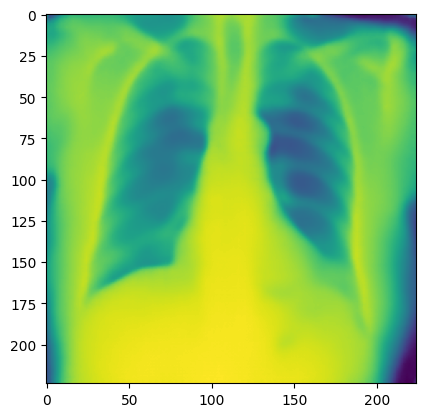

In [3]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic")
clf = xrv.models.DenseNet(weights="all")
ae = ae.cuda()
ae.zero_grad()

z = ae.encode(x[:,:1]).detach()
z.requires_grad = True
x_lambda0 = ae.decode(z)
plt.imshow(x_lambda0.detach()[0,0].cpu())


In [4]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic")
clf = xrv.models.DenseNet(weights="all")
ae = ae.cuda()
clf = clf.cuda()


In [5]:
ae

XRV-ResNetAE-101-elastic

In [6]:
from utils import generate_explanation,generate_vector,generate_vector_cav,calc_iou
target = "Cardiomegaly"
sample = nih_ds[1]

image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()
vector = generate_vector(image,target,ae=ae,clf=clf)
dimage,xp = generate_explanation(sample, vector, target, ae=ae, clf=clf)


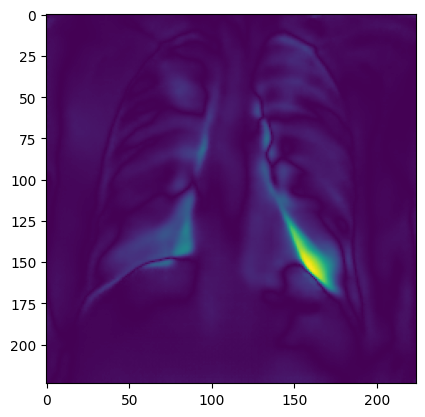

In [7]:
plt.imshow(dimage)

In [8]:
from src.models.chexzero_plus.clip import *
from src.models.chexzero_plus.model import CLIP
from src.models.chexzero_plus.simple_tokenizer import SimpleTokenizer
def load_clip(model_path=None, pretrained=False, context_length=77):
    '''
    FUNCTION: load_clip
    -------------------------------
    This function loads in a model with the CLIP model 
    architecture. 
    
    args: 
        * model_path (optional) - path to model weights that the model
        will be initialized with 
        * pretrained (optional) - if True, will load the pretrained 
        CLIP model
        * context_length (optional) - length of the maximum number of 
        tokens that can be inputted into the CLIP model
    '''

    params = {
        'embed_dim':768,
        'image_resolution': 320,
        'vision_layers': 12,
        'vision_width': 768,
        'vision_patch_size': 16,
        'context_length': context_length,
        'vocab_size': 49408,
        'transformer_width': 512,
        'transformer_heads': 8,
        'transformer_layers': 12
    }
        
    # set device 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    if pretrained: 
        # load clip pre-trained model
        model, preprocess = load("ViT-B/32", device=device, jit=False)
        print("Loaded in pretrained model.")
    else: 
        model = CLIP(**params)
        print("Loaded in clip model.")
    
    # if a model_path is provided, load in weights to backbone
    if model_path != None: 
        model.load_state_dict(torch.load(model_path, map_location=device))
    return model

mm = torch.load("/home/luab/experiments/ChexZero/0.1c/checkpoints/epoch=7-step=8504.ckpt")
n_d = {k.lstrip("backbone."):v  for k,v in mm['state_dict'].items()}
model = load_clip(pretrained=True)
model.load_state_dict(n_d)

Loaded in pretrained model.


<All keys matched successfully>

In [9]:
def forward_func(x):
    x_t = transform(x)
    #x_t.requires_grad = True
    image_features = model.encode_image(x_t) 
    texts = ["The cardiac silhouette is within upper limits of normal in size"] # format with class
    texts = tokenize(texts, context_length=77).cuda() # tokenize
    text_features = model.encode_text(texts)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    image_features_1 = image_features/image_features.norm(dim=-1, keepdim=True) # (1, 768)

    # obtain logits
    logits = image_features_1 @ text_features.t() # (1, num_classes)
    #logits = np.squeeze(logits.cpu().numpy(), axis=0) # (num_classes,)
    return logits
target = 0
varbose = True
fix_range = None
search_pred_diff: float = 0.8
search_step_size: float = 10
search_max_steps: int = 100000
search_max_pixel_diff: float = 100.0
lambda_sweep_steps: int = 10
heatmap_method: str = "max"
verbose: bool = True


In [10]:
model.zero_grad()
ae.zero_grad()
model = model.eval()

In [12]:
x.max()

tensor(942.3572, device='cuda:0')

In [13]:
z = ae.encode(x[:,:1]).detach()
z.requires_grad = True
x_lambda0 = Normalize(0,1024)(ae.decode(z))
# predict
pred = forward_func(torch.stack([x_lambda0]*3,dim=2).squeeze(0))[:, 0]
dzdxp = torch.autograd.grad(pred, z)[0]
#dzdxp = torch.nn.functional.normalize(dzdxp)
# Cache so we can reuse at sweep stage
cache = {}

def compute_shift(lambdax):
    """Compute the shift for a specific lambda"""
    if lambdax not in cache:
        x_lambdax = Normalize(0,1024)(ae.decode(z + dzdxp * lambdax).detach())
        pred1 = torch.sigmoid(forward_func(torch.stack([x_lambdax]*3,dim=2).squeeze(0)))[:, target]
        pred1 = pred1.detach().cpu().numpy()
        cache[lambdax] = x_lambdax, pred1
        if verbose:
            print(f"Shift: {lambdax} , Prediction: {pred1}")
    return cache[lambdax]

_, initial_pred = compute_shift(0)

if fix_range:
    lbound, rbound = fix_range
else:
    # Left range
    lbound = 0
    last_pred = initial_pred
    while True:
        x_lambdax, cur_pred = compute_shift(lbound)
        pixel_diff = torch.abs(x_lambda0 - x_lambdax).sum().detach()

        # If we stop decreasing the prediction
        if last_pred < cur_pred:
            break
        # If the prediction becomes very low
        if cur_pred < 0.05:
            break
        # If we have decreased the prediction by pred_diff
        if initial_pred - search_pred_diff > cur_pred:
            break
        # If we are moving in the latent space too much
        if lbound <= -search_max_steps:
            break
        # If we move too far we will distort the image
       # if pixel_diff > search_max_pixel_diff:
       #     break

        last_pred = cur_pred
        lbound = lbound - search_step_size + lbound // 10

    # Right range search not implemented
    rbound = 0
    #last_pred = initial_pred
    #while True:
    #    xpp, cur_pred = compute_shift(rbound)
    #    #print("rbound",rbound, "last_pred",last_pred, "cur_pred",cur_pred)
    #    if last_pred > cur_pred:
    #        break
    #    if initial_pred+0.05 < cur_pred:
    #        break
    #    if rbound >= 1000:
    #        break
    #    last_pred = cur_pred
    #    if np.abs(rbound) < search_step_size:
    #        rbound = rbound + 1
    #    else:
    #        rbound = rbound + search_step_size
if verbose:
    print("Selected bounds: ", lbound)

# Sweep over the range of lambda values to create a sequence
lambdas = np.arange(
    lbound, rbound, np.abs((lbound - rbound) / lambda_sweep_steps)
).tolist()

preds = []
generated_images = []

for lam in lambdas:
    x_lambdax, pred = compute_shift(lam)
    generated_images.append(x_lambdax.cpu().numpy())
    preds.append(float(pred))

params = {}
params["generated_images"] = generated_images
params["lambdas"] = lambdas
params["preds"] = preds

x_lambda0 = x_lambda0.detach().cpu().numpy()
if heatmap_method == "max":
    # Max difference from lambda 0 frame
    heatmap = np.max(np.abs(x_lambda0[0][0] - generated_images[0][0]), 0)

elif heatmap_method == "mean":
    # Average difference between 0 and other lambda frames
    heatmap = np.mean(np.abs(x_lambda0[0][0] - generated_images[0][0]), 0)

elif heatmap_method == "mm":
    # Difference between first and last frames
    heatmap = np.abs(generated_images[0][0][0] - generated_images[-1][0][0])

elif heatmap_method == "int":
    # Average per frame differences
    image_changes = []
    for i in range(len(generated_images) - 1):
        image_changes.append(
            np.abs(generated_images[i][0][0] - generated_images[i + 1][0][0])
        )
    heatmap = np.mean(image_changes, 0)
else:
    raise Exception("Unknown heatmap_method for 2d image")

params["heatmap"] = heatmap


Shift: 0 , Prediction: [0.557]
Shift: -10 , Prediction: [0.557]
Shift: -21 , Prediction: [0.557]
Shift: -34 , Prediction: [0.557]
Shift: -48 , Prediction: [0.557]
Shift: -63 , Prediction: [0.557]
Shift: -80 , Prediction: [0.557]
Shift: -98 , Prediction: [0.557]
Shift: -118 , Prediction: [0.557]
Shift: -140 , Prediction: [0.557]
Shift: -164 , Prediction: [0.557]
Shift: -191 , Prediction: [0.557]
Shift: -221 , Prediction: [0.557]
Shift: -254 , Prediction: [0.557]
Shift: -290 , Prediction: [0.557]
Shift: -329 , Prediction: [0.557]
Shift: -372 , Prediction: [0.557]
Shift: -420 , Prediction: [0.557]
Shift: -472 , Prediction: [0.557]
Shift: -530 , Prediction: [0.557]
Shift: -593 , Prediction: [0.557]
Shift: -663 , Prediction: [0.557]
Shift: -740 , Prediction: [0.557]
Shift: -824 , Prediction: [0.557]
Shift: -917 , Prediction: [0.557]
Shift: -1019 , Prediction: [0.557]
Shift: -1131 , Prediction: [0.557]
Shift: -1255 , Prediction: [0.557]
Shift: -1391 , Prediction: [0.557]
Shift: -1541 , Predi

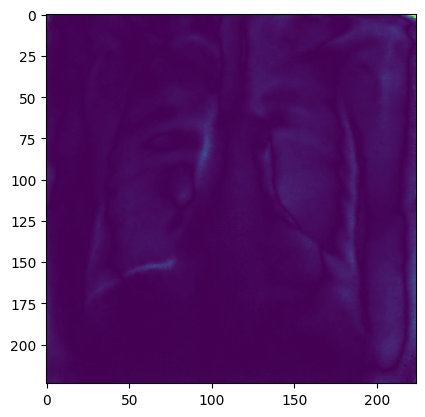

In [14]:
import matplotlib.pyplot as plt
plt.imshow(heatmap)

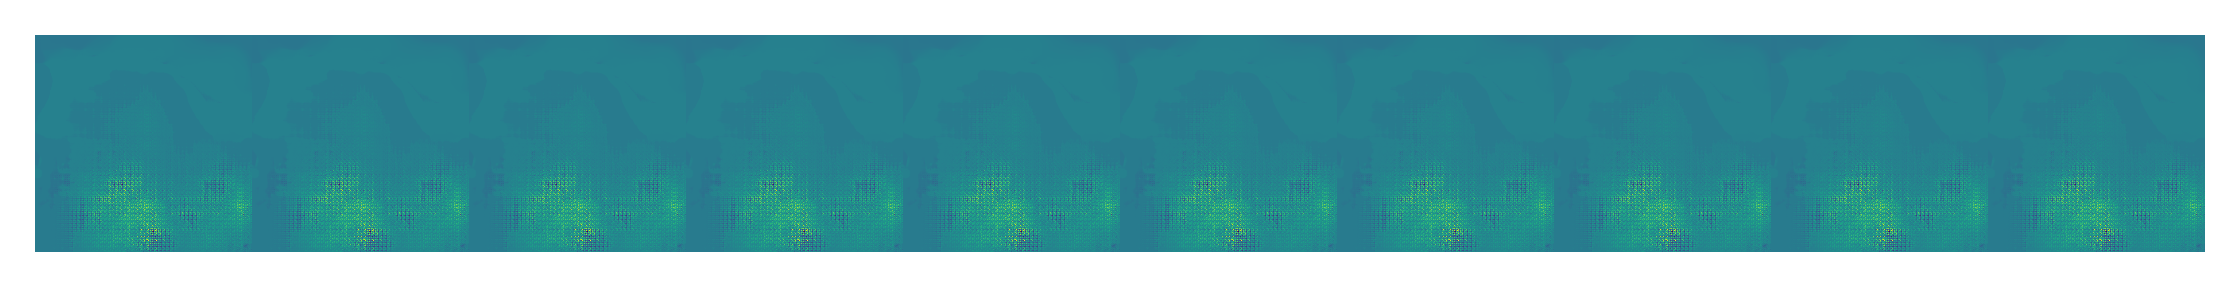

In [25]:
images_f = [h.transpose(0, 2, 3, 1) for h in params["generated_images"]]
dimgs = np.concatenate(images_f)
fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=350)
plt.imshow(np.concatenate(dimgs,1), interpolation='none');
plt.axis('off');

In [77]:
dimgs = np.concatenate([images_f[0],torch.stack([torch.tensor(x_lambda0)]*3,dim=2).squeeze(0)[0], images_f[-1]])
fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=350)
plt.imshow(np.concatenate(dimgs,1), interpolation='none');
plt.axis('off');

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)

In [194]:
images_f

[array([[[[ 0.13565315],
          [ 0.24533632],
          [ 0.07564144],
          ...,
          [-0.8808129 ],
          [-0.85188514],
          [-0.82836205]],
 
         [[ 0.1280932 ],
          [ 0.24702163],
          [ 0.01903805],
          ...,
          [-0.9090105 ],
          [-0.90258014],
          [-0.9114934 ]],
 
         [[ 0.2187183 ],
          [ 0.15509476],
          [-0.2111056 ],
          ...,
          [-0.9281403 ],
          [-0.91525704],
          [-0.9142695 ]],
 
         ...,
 
         [[ 0.7950991 ],
          [ 0.7655721 ],
          [ 0.4532086 ],
          ...,
          [-0.8858555 ],
          [-0.92092055],
          [-0.8880117 ]],
 
         [[ 0.74456865],
          [ 0.71296614],
          [ 0.51124024],
          ...,
          [-0.80585873],
          [-0.7970013 ],
          [-0.7571284 ]],
 
         [[ 0.5761097 ],
          [ 0.65966785],
          [ 0.5469584 ],
          ...,
          [-0.7733989 ],
          [-0.8236081 ],
    

In [179]:
x_lambda0.shape

(1, 1, 224, 224)

In [11]:
x_lambda0 = Normalize(0,1024)(x)
x_lambda0.requires_grad = True
pred = forward_func(torch.stack([x_lambda0]*3,dim=2).squeeze(0))[:, 0]
dzdxp = torch.autograd.grad(pred, x_lambda0)[0]


NameError: name 'forward_func' is not defined

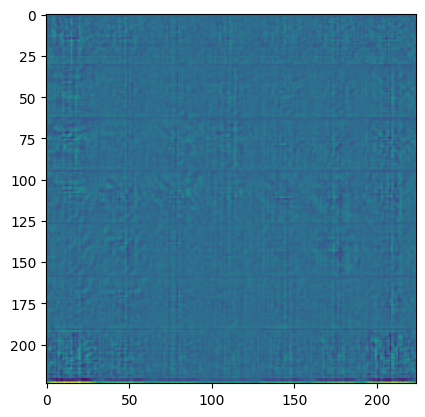

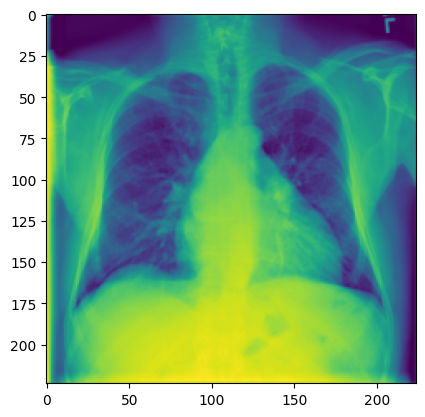

In [165]:
plt.imshow(1000*dzdxp.cpu()[0,0])
plt.show()
plt.imshow(x_lambda0.detach().cpu()[0,0])